# Astrodynamics
### A walkthrough of my work
#### Evan Bauer
#### http://github.com/evan-bauer/astrodynamics
#### Updated 01/04/20

## Section 1: Introduction and Motivation

Welcome! 

Several years ago, soon after my fascination with orbital mechanics originally began, I read about the legacy of the Voyager probes and immediately became enamored with the phenomenon known as a gravity assist. I tried a few times to work out exactly how these orbital maneuvers work (to no avail on account of my lack of physics knowledge at the time). When the opportunity arose to make a final project for my classical mechanics class, I finally had enough of a foundation to make sense of the seemingly "free energy". 

The original project was built on a gross number of assumptions perhaps the most egregious being I only considered two dimensions. This continuation and elaboration of the original work displayed hereafter contains some adaptations of the progenitor among countless other improvements, optimizations, and new features.

Anyway, we'll start with importing standard libraries and the subject of this walkthrough: `Astrodynamics`:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
from scipy.signal import argrelmin
from Astrodynamics import *

Now we can begin by defining some basic characteristics of a hypothetical circular orbit of a 900kg satellite around an Earth-like planet with a seemi-major axis of 7,000 km, analagous to a low-Earth orbit. Also defined here are some characteristics of a Jupiter-like planet and the Moon.

In [2]:
G = 6.67430e-11                                             #  N m^2 kg^-2
m_probe, M_star = 900, 1.98847e30                           #  kg
M_home, M_dest, M_moon = 5.9722e24, 1.9e27, 7.34767309e22   #  kg
a_initial, a_home, a_moon = 7e6, 150e9, 384748e3            #  m
P_dest = 12 * 365 * 24 * 60**2                              #  s
a_dest = np.cbrt(G * M_star * P_dest**2 / (4 * np.pi**2))   #  K2L
v_initial = np.sqrt(G * M_home / a_initial)                 #  m/s
v_esc = v_initial * np.sqrt(2)                              #  m/s
v_home = np.sqrt(G * M_star / a_home)                       #  m/s
r_earth, r_sun, r_moon = 6371e3, 6.957e8, 1737.4e3          #  m
r_jupiter, AU = 7.1492e7, 149597871000                      #  m

## Section 2: Basic Information 

With `Astrodynamics`, there are several components used in defining a multiple-body system and a combination of various specifically-defined classes, including:
- `System()`
    - The `System` object is a combination of a  number of each of the following classes and is critical for the functionality of the `Simulate` class later on. Simply put, a `System` object is based around a provided `Body` object describing the most massive celestial object and includes less massive `Body` objects and their respective `OrbitalParameters`. Furthermore, once orbiting bodies are defined, the `Body` object will be assigned a `SOI` attribute correspoonding to the object's gravitational sphere of influence.
    - Methods
        - `define_planet(body, a, arg_periapsis=0, long_asc_node=0, inclination=0)`: Add planet to `System`
            - `body`: A `Body` object to transform into an orbiting planet
            - `a`: The semi-major axis of the orbit
            - `arg_periapsis`: Argument of periapsis (in degrees) for the orbiting body (default = 0$\degree$)
            - `long_asc_node`: Longitude of ascending node (in degrees) for the orbiting body (default = 0$\degree$)
            - `inclination`: Orbital inclination (in degrees) for the orbiting body (default = 0$\degree$)
        - `define_planet_vectors(body, a, e, inclination, arg_periapsis, long_asc_node, ecc_anom)`: Add planet to `System` from Keplerian orbital elements
            - `body`: A `Body` object to transform into an orbiting planet
            - `a`: Semi-major axis of the orbit
            - `e`: Eccentricity
            - `inclination`: Orbital inclination (in degrees) for the orbiting body
            - `arg_periapsis`: Argument of periapsis (in degrees) for the orbiting body
            - `long_asc_node`: Longitude of ascending node (in degrees) for the orbiting body
            - `ecc_anom`: Eccentric anomaly (in degrees) for the orbiting body
        - `set_eccentric_anomaly(body, ecc_anom)`
            - `body`: The `Body` object in the current `System` to alter the position of
            - `ecc_anom`: Eccentric anomaly (in degrees) to set the orbiting body at
        - `set_true_anomaly(body, true_anom)`
            - `body`: The `Body` object in the current `System` to alter the position of
            - `true_anom`: True anomaly (in degrees) to set the orbiting body at
    - Attributes
        - `primary`: The `Body` object defined as the primary of the system
        - `satellites`: `dict` object containing `Body` object(s) where lesser `System` objects (e.g. the Earth-Moon `System`) are regarded as a single `Body`
        - `mass`: Total mass of the `System`
        - `name`: Name of the `System` combining the names of each constituent celestial object of the `System` into one string
- `Body(name, mass, radius)`
    - Defines a celestial body or satellite object
    - Methods
        - `apply_state_vectors(*line)`
            - This will be used later on, particularly when it comes to simulation. Also, I think this can be more cleanly done throughstrategic use of a wrapper/decorator
        - `true_anomaly()`: Returns the true anomaly of the `Body` in its orbit when the `OrbitalProperties` object is defined under the `orbit` attribute
        - `eccentric_anomaly()`: Returns the eccentric anomaly of the `Body` in its orbit when the `OrbitalProperties` object is defined under the `orbit` attribute
        - `mean_anomaly()`: Returns the mean anomaly of the `Body` in its orbit when the `OrbitalProperties` object is defined under the `orbit` attribute
    - Attributes
        - `name`: Name of the `Body` \* **NOTE**: This *needs* revision because I don't think I wrote a clear way to access an underlying `System` object from its `Body` simplification .___.
        - `mass`: Mass of the `Body`
        - `radius`: Radius of the `Body` (default = 1km)
        - `orbit`: `OrbitalProperties` object defined manually or after adding the `Body` to a `System`
- `OrbitalProperties(source, data, mode=None, secondary_mass=m_probe, arg_periapsis=0, long_asc_node=0, inclination=0)`
    - Retains information regarding the state of an object's orbit and may be the most complex aspect of this whole project just trying to make it as "unbreakable" as possible although is fairly confusing...####
    - Attributes
        - `secondary_mass`: Mass of the secondary (orbiting) `Body` (default = 900kg)
        - `about`: Dominant gravitational presence about which
        - `position`: Cartesian position vector of the orbiting `Body` or `System`
        - `velocity`: Cartesian velocity vector of the orbiting `Body` or `System`
        - `a`: Trajectory semi-major axis
        - `e`: Eccentricity magnitude ($e \geq 0$)
        - `e_vector`: Eccentricity vector
        - `h`: Specific angular momentum magnitude
        - `h_vector`: Specific angular momentum vector
        - `inclination`: Orbital inclination (default = 0$\degree$)
        - `arg_periapsis`: Argument of periapsis (default = 0$\degree$)
        - `long_asc_node`: Longitude of the ascending node (default = 0$\degree$)
        - `ecc_anom`: Eccentric anomaly
        - `energy`: Specific  orbital energy of the defined trajectory
        - `orbit`: Type of trajectory
        - `T`: Orbital period (in seconds)
        - `periapsis`: `Apsis` object describing the periapsis
        - `apoapsis`: `Apsis` object describing the apoapsis
    - Methods
        - `velocity(*arg)`: Returns the magnitude of the velocity of an orbiting object at the specified radial distance (default = current radial distance)
        - `flight_path_angle()`: Returns the angle between the **RADIAL** and velocity vectors
        - `flight_path_angle_gamma()`: Returns the angle between the **TANGENT** and velocity vectors
        - `true_anomaly(*r)`: Returns the true anomaly of the orbiting object at specified radii or `"Undefined"` for a circular orbit
        - `inclination()`: Returns the orbital inclination (in degrees) of the trajectory
        - `apply_state_vectors(line)`: Updates the current `OrbitalProperties` to emulate the simulated state of an orbiting body at a specific simulated row solution
        - `escape_SOI(excess=None)`: Returns the necessary prograde increase in velocity for the secondary body to escape the primary's sphere of gravitational influence (default = 0 m/s hyperbolic excess velocity)
        - `plot_potential(y_window=None, r_max=None)`: Returns a plot of the effective potential corresponding to the given `OrbitalProperties`
- `Apsis`
    - Stores information about the nearest and most distant points of an orbiting body to the primary
    - Methods
        - None yet, may want to expand this quite a bit
    - Attributes
        - `distance`: Radial distance of apsis
        - `velocity`: Tangential velocity magnitude at apsis
     
## Section 3: Navigating the Solar System
To get started faster, I included the following function to create a `System` object about the Sun with Jupiter and the Earth-Moon system:

In [3]:
solsys = create_advanced_system()
vars(solsys)

{'primary': Sun,
 'satellites': {'EarthMoonSystem': EarthMoonSystem, 'Jupiter': Jupiter},
 'mass': 1.99037424559e+30,
 'name': 'SunEarthMoonSystemJupiterSystem'}

Let's take a look at Jupiter:

In [4]:
jupiter = solsys.satellites["Jupiter"]
vars(jupiter)

{'name': 'Jupiter',
 'mass': 1.8982e+27,
 'radius': 69911000,
 'orbit': Elliptical orbit with semi-major axis 778477401.1km and eccentricity 0.0,
 'SOI': 48214223865.34796}

Evidently, accessing the `Body` object representing Jupiter from the `System` includes the exact attributes we would expect: `name`, `mass`, `radius`, `orbit`, and because Jupiter is part of the `System` object with the Sun as the primary, the radius of Jupiter's sphere of influence `SOI` is also calculated. Similarly, because Jupiter is a part of the `System` object, there's automatically an `OrbitalProperties` object created with the attributes:

In [5]:
vars(jupiter.orbit)

{'secondary_mass': 1.8982e+27,
 'about': SunEarthMoonSystemJupiterSystem,
 'position': array([ 7.13270072e+11,  1.82511499e+11, -7.83716335e+10]),
 'velocity': array([-3390.47091238, 13292.38859888,    98.15209092]),
 'a': 778477401109.8003,
 'e': 0.048899999999997494,
 'e_vector': array([ 0.04710757,  0.01205388, -0.00517602]),
 'h': 1.0157185218237492e+16,
 'h_vector': array([1.05966009e+15, 1.95707795e+14, 1.00998629e+16]),
 'inclination': 0.1062905514464546,
 'arg_periapsis': -1.5033044446202763,
 'long_asc_node': 1.7534275797235832,
 'ecc_anom': 3.5544836482820817e-16,
 'energy': -1.6195950131186072e+35,
 'orbit': 'Elliptical',
 'T': 374436907.1520108,
 'periapsis': Apsis at r=740409856.2km, v=13.718km/s,
 'apoapsis': Apsis at r=816544946.0km, v=12.439km/s}

We can plot the effective potential of Jupiter's orbit as follows:

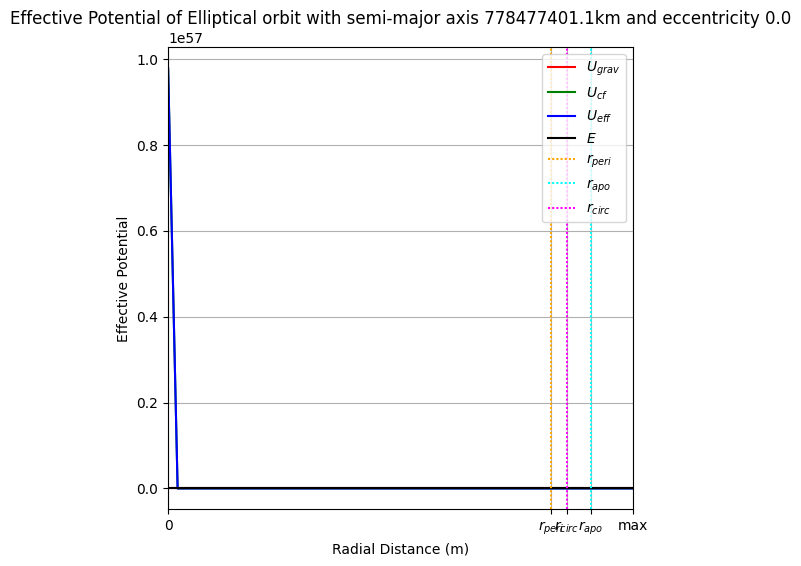

In [6]:
jupiter.orbit.plot_potential()

This choice of y-coordinates is effectively impossible to read, so let's change the range of orbital energies to display:

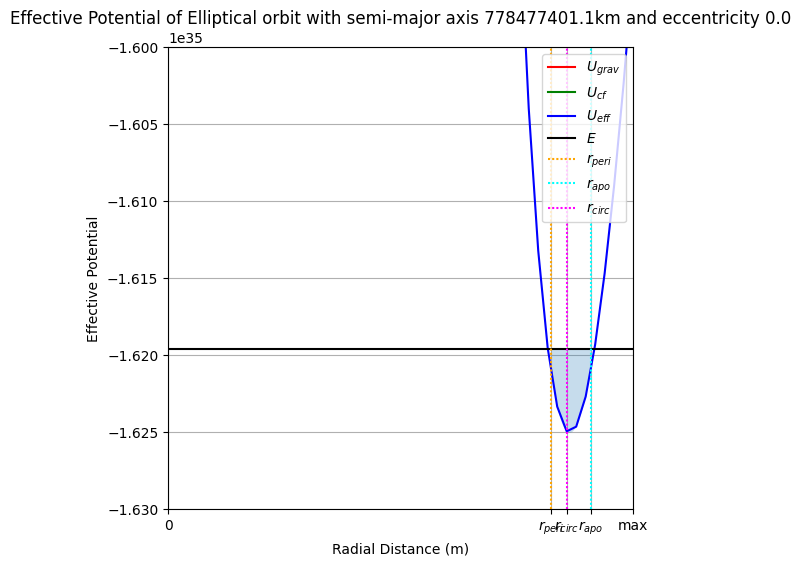

In [7]:
jupiter.orbit.plot_potential(y_window=[-1.63e35, -1.6e35])

Upon close inspection, it appears that the vertical lines are slightly offset from where the intersect between orbital energy and the the effective potential meet. This is primarily a result of the intervals between radial points for which values are calculated accentuated by the very low eccentricity of Jupiter's orbit. Highly eccentric orbits are much better represented in these such plots and look better in general.

## Section 4: Simulating an encounter

Now we can simulate a basic orbital encounter between a low-mass object like a probe and a massive `Body` like Jupiter. First, we need to initialize a `Simulate` object to serve as the framework for simulating orbiting objects. At present, there are two way to do this, either from a `System` object or another `Simulate` object, though both require a `System` object. The relevant bodies to simulate trajectorries for can be drawn from the previously mentioned `System` object supplied in creating the `Simulate` object with the method `draw_state_from_system(*args)` where the argument(s) correspond to the name(s) of satellite objects defined in the `Systtem`. Now to create a probe by supplying a `Body` object, the original `System` object, and the position and velocity vectors of the probe:

In [8]:
sim = Simulate(solsys)
sim.draw_state_from_system("Jupiter", "EarthMoonSystem")
sim.make_probe(Body("Probe", 900, 0), solsys, np.array([4.6038 * AU, 2*AU, 1]), np.array([-1e3, 7e3, -2000]))

Simulation object with primary secondary probe

And finally, it is time to simulate! Just plug in the length of time to simulate (and an optional `timestep`) and the solution will be calculated. The distance of the closest approach of the probe to each the primary and secondary bodies will be printed:

In [9]:
sim.simulate(180.8, timestep="days")

Closest approach with primary: 83383938.48595539Mm
Closest approach with secondary: 747863072.2172561Mm


Simulation object with primary secondary probe

Plotting the simulated trajectories is fairly straightforward and turns out very well when the viewing windows are of equal ranges. If the `encounter` argument is defined, which corresponds to an integer value (representing an index in the solution array) where the probe enters the spherre of influence of a more massive `Body`, plotting the solutions will end at the point of encounter:

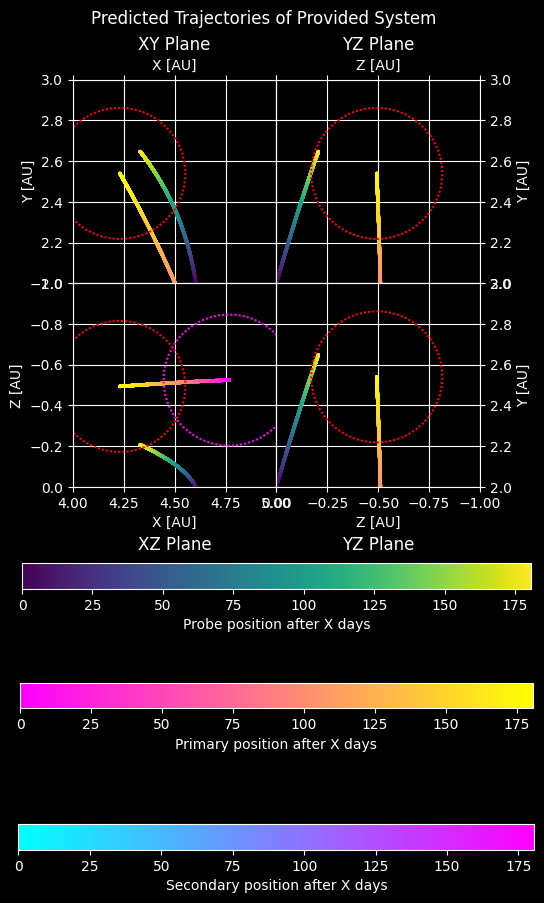

In [10]:
sim.plot_simulation(x_window=[4, 5], y_window=[2, 3], z_window=[0, -1], encounter=749128, markevery=100)

This next plot depicts the same as above but includes the simulated orbits of all involved bodies and clearly doesn't restrict the plotting window for each axis so it's a bit... ugly. Moreover, I think it highlights an issue I still haven't found a way to resolve: stacking each of the colorbars on top of one another and moving the labels inside the bars.

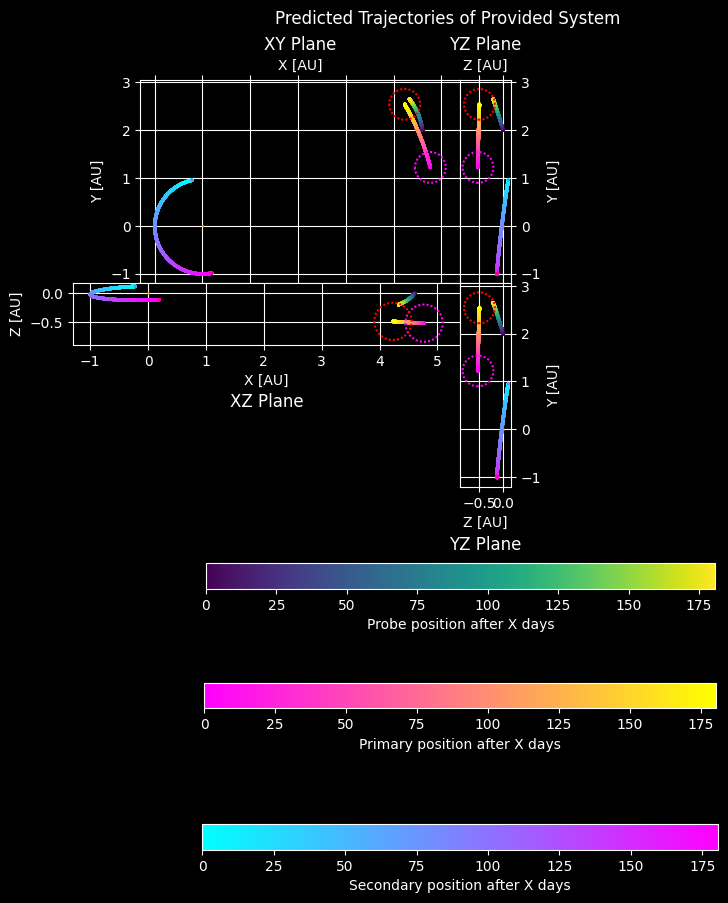

In [11]:
sim.plot_simulation(encounter=749128, markevery=100)